# Nistats tutorial
This notebook is about the functionality of [nistats](https://nistats.github.io/) Python package for statistical analysis of fMRI data. While it is still in development, it promises to become a full-fledged Python-based alternative to existing (f)MRI analysis software packages such as FSL, SPM, and AFNI.

In this notebook, we'll showcase the most important features of the package in a step-by-step fashion. Notably, this notebook contains several exercises (which we call "ToDos"), which are meant to make this tutorial more interactive! Also, this tutorial is merely an introduction to (parts of) the Nistats package. We strongly recommend checking out the excellent [user guide](https://nistats.github.io/user_guide.html) and [example gallery](https://nistats.github.io/auto_examples/index.html) on the Nistats website if you want to delve deeper into the package's (more advanced) features.

While not strictly necessary, you'll get the most out of this tutorial if you are familiar with the Nilearn package. To familiarize yourself, you could check out the [Nilearn website](https://nilearn.github.io/) and/or go through our [Nilearn tutorial](https://github.com/lukassnoek/nilearn-tutorial). (For students doing either of the *Neuroimaging* courses at the University of Amsterdam: the `nilearn.ipynb` notebook should be in your home-folder already.) Also, this notebooks contains a very short introduction to the [pandas](https://pandas.pydata.org/) package, but this can be skipped by those who are already familiar with it.

### Contents
1. What is Nistats?
2. Data formats
3. Creating design matrices
4. First-level models
5. Second-level models

**Estimated time needed to complete**: 1-3 hours (depending on your experience with Python)<br>
**Credits**: if you end up using `nistats` in your work, please cite the corresponding [article](https://www.frontiersin.org/articles/10.3389/fninf.2014.00014/full).<br>

In [1]:
# We need to limit the amount of threads numpy can use, otherwise
# it tends to hog all the CPUs available when using Nistats
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np

## 1. What is Nistats?
Nistats is one of the packages in the growing "nipy" ecosystem of Python packages for neuroimaging analysis (see also MNE, nilearn, nipype, nibabel, and dipy). Specifically, Nistats provides tools for statistical (mostly univariate) analysis of fMRI data. Internally, it relies heavily on the [Nilearn](https://nilearn.github.io/) package. Importantly, Nistats does not contain functionality to preprocess your (f)MRI data and assumes that your data has been preprocessed by another software package. Personally, we think it works very well in combination with preprocessed data using the [Fmriprep](https://fmriprep.readthedocs.io/) package.

<div class='alert alert-warning'>
    <b>ToDo</b>: Go through the <a href='https://nistats.github.io/'>Nistats</a> website to get an idea of what functionality the package offers.
</div>

On the Nistats website, you can see that the package contains several modules (such as `datasets`, `design_matrix`, `first_level_model`, etc.). In the following sections, we will discuss some of them.

<div class='alert alert-danger'>
    <b>Note</b>: Nistats is a relatively new package and its API might change! If code in this notebook gives errors because it uses an old version of Nilearn, let us know. 
</div>

## 2. Data formats
The two most important data formats that are used in the Nistats package are nifti images and comma- or tab-separated values (CSV, TSV) text files.

### 2.1. Nifti images
Like most packages in the *nipy* ecosystem, Nistats assumes that your MRI data is stored in nifti images. Like Nilearn, many functions in Nistats involving nifti images accept either strings pointing towards the path of a nifti file (or a list with multiple paths) or a `Nifti1Image` object from the `nibabel` package. Together, these two types of inputs (filenames pointing to nifti files and `Nifti1Images`) are often referred to a "niimgs" (or "niimg-like") by Nistats — a term you'll see a lot in the documentation.

In fact, many internal operations involving nifti images within Nistats are dealt with using Nilearn. When using Nistats, however, you'll notice that most of these operations are abstracted away, and you'll rarely have to deal with (pre)processing nifti images directly.

Let's actually download some data! In this tutorial, we use data from the [NARPS](https://www.narps.info/) project ([Botvinik-Nezer et al., 2019a](https://www.nature.com/articles/s41597-019-0113-7); [Botvinik-Nezer et al., 2019b](https://www.biorxiv.org/content/10.1101/843193v1)). This public dataset was analyzed by 70 different research groups to showcase the variety in analysis approaches and the way this affects the subsequent results. In the study, a "mixed gambles" experiment was used to investigate how potential monetary gains and losses are related to brain activity (which was based on the experiment by [Tom et al., 2007](https://science.sciencemag.org/content/315/5811/515)). Each trial, participants were presented simulatenously with a potential monetary "gain" (e.g., <b><font color='green'>+12</font></b>) and a potential monetary "loss" (e.g., <b><font color='red'>-6</font></b>. For each trial, participants had to choose whether to accept this gamble (either "strongly accept", "weakly accept", "weakly reject", or "strongly reject"), knowing that at the end of the experiment, one trial ("gamble") would be picked randomly and (if chosen) would be "run" with a 50/50 chance of losing the original "loss" amount and winning the original "gain" amount. As such, the following information was recorded per trial: potential gain amount, potential loss amount, reaction time (of participant's response), and the participant's choice/decision. 

<div class='alert alert-warning'>
    <b>ToDo</b>: Go to the <a href='https://www.narps.info/analysis.html'>NARPS website</a> and read through the "data and analysis" section to get an idea of the experiment and scanning procedure.
</div>

The dataset is publicly available from [Openneuro.org](http://openneuro.org/), which also includes preprocessed data (using [Fmriprep](https://fmriprep.readthedocs.io/)) &mdash; perfect for our purposes! The cell below will download the data, which may take a while because it's 2.4 GB in size.

In [4]:
# We'll save the data in your home folder
# Note: the os.path.join function concatenates paths using the delimiter specific
# to your operating system (\ for windows, / for Mac/Linux)
import os 
save_dir = os.path.join(os.path.expanduser("~"), 'NARPS')
if not os.path.isdir(save_dir):
    print("Data will be saved in %s ..." % save_dir)
    print("Go get some coffee. This may take a while.\n")

    # Using the CLI interface of the `awscli` Python package, we'll download the data
    # Note that we only download the preprocessed data from a single run from a single subject
    # This may take about 10-60 minutes or so (depending on your download speed)
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001734 {save_dir} --exclude "*" --include "*fmriprep/sub-00[1,3]/func/*run-01*space-MNI*.nii.gz"
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001734 {save_dir} --exclude "*" --include "*fmriprep/sub-00[1,3]/func/*run-01*.tsv"
    !aws s3 sync --no-sign-request s3://openneuro.org/ds001734 {save_dir} --exclude "*" --include "*sub-00[1,3]/func/*run-01*events.tsv"
    print("\nDone!")
else:
    print("Data is already downloaded!")

Data will be saved in /Users/Dominik/NARPS ...
Go get some coffee. This may take a while.

download: s3://openneuro.org/ds001734/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz to ../../../NARPS/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
download: s3://openneuro.org/ds001734/derivatives/fmriprep/sub-003/func/sub-003_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz to ../../../NARPS/derivatives/fmriprep/sub-003/func/sub-003_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
download: s3://openneuro.org/ds001734/derivatives/fmriprep/sub-003/func/sub-003_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz to ../../../NARPS/derivatives/fmriprep/sub-003/func/sub-003_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
download: s3://openneuro.org/ds001734/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MN

Alright, let's check out the directory in which we saved the downloaded data:

In [5]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
list_files(save_dir)

NARPS/
    derivatives/
        fmriprep/
            sub-003/
                func/
                    sub-003_task-MGT_run-01_bold_confounds.tsv
                    sub-003_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
                    sub-003_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
            sub-001/
                func/
                    sub-001_task-MGT_run-01_bold_confounds.tsv
                    sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz
                    sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz
    sub-003/
        func/
            sub-003_task-MGT_run-01_events.tsv
    sub-001/
        func/
            sub-001_task-MGT_run-01_events.tsv


As you can see, this directory contains both subdirectories with "unprocessed" data (in `sub-001/func`) and preprocessed data (in `derivatives/fmriprep/sub-001/func`). Note that we excluded the raw (unprocessed) MRI data to save disk space (and time).

Now, let's check out an fMRI file. We'll load the preprocessed `sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz` (which has been registered and resampled to standard MNI152 space already) using `nibabel`:

In [7]:
import nibabel as nib
fmri_path = os.path.join(save_dir, 'derivatives', 'fmriprep', 'sub-001', 'func', 'sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
fmri = nib.load(fmri_path)

<div class='alert alert-warning'>
    <b>ToDo</b>: Do you remember how to inspect <tt>Nifti1Images</tt> from <tt>nibabel</tt>? Try to figure out this scan's TR and how many volumes (timepoints) this file has. Store the TR in a variable named <tt>tr_todo</tt> and the number of volumes in <tt>nvol_todo</tt>. 
</div>

In [16]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
tr_todo = fmri.header["pixdim"][4]
nvol_todo = fmri.header["dim"][4]

In [17]:
''' Tests the ToDo above. '''
assert(tr_todo == 1)
assert(nvol_todo == 453)
print("Well done!")

Well done!


### 2.2. TSV files (or: a short introduction to Pandas)
*(If you're familiar with the Pandas package, you may skip this section.)*

The other type of file you'll probably encounter a lot when working with nistats is a TSV (tab-separated values) file. This plain-text file is like a spreadsheet with different "observations" in rows and different "attributes" in columns. For example, according to the Brain Imaging Data Structure ([BIDS](https://bids.neuroimaging.io/)), information about your experiment (like trial onsets, durations, conditions, etc.) should be stored in a TSV file ending in `_events.tsv`. 

As expected, the data we downloaded also contains such an event-file, `sub-001_task-MGT_run-01_events.tsv`. (Note that these event-files are stored in the "unprocessed" data directory, not the "derivatives" directory).

These TSV files can be loaded into Python using the [pandas](https://pandas.pydata.org/) package. `pandas` is usually imported as follows:

In [18]:
import pandas as pd

Then, TSV files (or any x-delimited files, like CSV files) can be loaded in using the `pd.read_csv` function. Let's do that for our events-file:

In [19]:
path = os.path.join(save_dir, 'sub-001', 'func', 'sub-001_task-MGT_run-01_events.tsv')
events_df = pd.read_csv(path, sep='\t')
events_df  # putting events_df at the end of a cell (instead of printing it) will show a nicely formatted table

,onset,duration,gain,loss,RT,participant_response
0,4.071,4,14,6,2.388,weakly_accept
1,11.834,4,34,14,2.289,strongly_accept
2,19.535,4,34,13,1.873,strongly_accept
3,27.535,4,10,10,1.457,weakly_reject
4,36.435,4,12,19,1.973,strongly_reject
...,...,...,...,...,...,...
59,416.033,4,18,14,1.764,weakly_accept
60,421.734,4,34,8,1.666,strongly_accept
61,427.535,4,30,17,1.249,strongly_accept
62,435.636,4,10,18,1.247,strongly_reject


<div class='alert alert-warning'>
    <b>ToDo</b>: What do you think the argument <tt>sep='\t'</tt> does? Try removing the argument to see what happens.
</div>

As you can see, the `pd.read_csv` function returns a table-like object with 64 rows (corresponding to the experiment's events/trials) and 6 columns (corresponding to different attributes of the trials, like onset, duration, etc.). The `events_df` is a custom Pandas object called a `DataFrame`:

In [20]:
print(type(events_df))

<class 'pandas.core.frame.DataFrame'>


Pandas `DataFrames` are similar to dataframes in the R programming language. A full introduction to Pandas is beyond the scope of this tutorial (see [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) for a nice introduction), but we'll highlight some useful Pandas-related functionality below.

One thing that is useful to know is that `DataFrames` have both row and column names. The row names are usually referred to as the `DataFrame`'s *index* (these are the elements left of the "onset" column, i.e., 0, 1, 2, ... 63). Row and column names can be of any type (strings, like the "onset" column, integers, like the row names in this `DataFrame`, etc.).

To select particular rows and/or columns, you can use the `.loc` and `.iloc` methods, where the `.loc` method selects based on the *name* of the row/column (like a dictionary) and the `.iloc` method selects based on the *position*(i.e., the "number") of the row/column (like a list).

The syntax of a `loc` and `iloc` based selection is as follows:

```
df.loc[row_name, col_name]
df.iloc[row_index, col_index]
```

Note that the square brackets (`[]`) are different than what you expect from a *method*, but the technicalities are beyond the scope of this tutorial.

Anyway, to for example select the `onset` column (and all rows), we can do the following:

In [21]:
# the : tells loc to select *all* the rows
events_df.loc[:, 'onset']

0       4.071
1      11.834
2      19.535
3      27.535
4      36.435
       ...   
59    416.033
60    421.734
61    427.535
62    435.636
63    441.024
Name: onset, Length: 64, dtype: float64

And to select the first ten rows (and all columns), we can do the following:

In [22]:
# Just like regular Python lists, iloc accepts slice syntax (like :10, or 5:12:2)
events_df.iloc[:10, :]

,onset,duration,gain,loss,RT,participant_response
0,4.071,4,14,6,2.388,weakly_accept
1,11.834,4,34,14,2.289,strongly_accept
2,19.535,4,34,13,1.873,strongly_accept
3,27.535,4,10,10,1.457,weakly_reject
4,36.435,4,12,19,1.973,strongly_reject
5,43.935,4,20,8,1.767,weakly_accept
6,50.535,4,28,9,1.561,strongly_accept
7,59.837,4,20,15,2.289,weakly_accept
8,65.838,4,10,7,2.287,weakly_accept
9,71.539,4,16,6,2.080,weakly_accept


<div class='alert alert-info'>
    <b>ToThink</b> In the example above, we used <tt>iloc</tt> to select the first ten rows of the <tt>DataFrame</tt>, but we could have also used <tt>loc</tt> for this purpose (try it out yourself by substituting <tt>loc</tt> for <tt>iloc</tt>). Why do you think this is the case? Is this always possible?
</div>

Note that you can also select multiple rows and/or columns at the same time by passing a list or tuple to the `loc` and `iloc` indexers:

In [23]:
events_df.loc[:, ['onset', 'duration']]

,onset,duration
0,4.071,4
1,11.834,4
2,19.535,4
3,27.535,4
4,36.435,4
...,...,...
59,416.033,4
60,421.734,4
61,427.535,4
62,435.636,4


In [24]:
events_df.iloc[[0, 5], :]

,onset,duration,gain,loss,RT,participant_response
0,4.071,4,14,6,2.388,weakly_accept
5,43.935,4,20,8,1.767,weakly_accept


<div class='alert alert-warning'>
    <b>ToDo</b>: Let's practice a little. Select from <tt>events_df</tt> all odd rows <em>in a single statement</em> and store it in a variable named <tt>odd_rows</tt>. For a refresher on slicing in Python, see <a href="https://www.pythoncentral.io/how-to-slice-listsarrays-and-tuples-in-python/">here</a>).
</div>

In [33]:
''' Implement the ToDo here. '''
# YOUR CODE HERE
odd_rows = events_df.iloc[1::2]

In [34]:
''' Tests the ToDo above. '''
import numpy as np
assert(odd_rows.shape == (32, 6))
np.testing.assert_array_equal(odd_rows.index, range(1, 64, 2))
print("Well done!")

Well done!


<div class='alert alert-warning'>
    <b>ToDo</b>: Select the last 10 rows and the onset and duration columns <em>in a single statement</em> and store it in a variable named <tt>last10_onset_duration</tt>.
</div>

In [47]:
events_df.iloc[-10:,[0,1] ]

,onset,duration
54,384.627,4
55,390.128,4
56,395.129,4
57,400.730,4
58,410.331,4
59,416.033,4
60,421.734,4
61,427.535,4
62,435.636,4
63,441.024,4


In [48]:
''' Implement the ToDo here. '''
# YOUR CODE HERE
last10_onset_duration = events_df.iloc[-10:,[0,1] ]

In [49]:
''' Tests the above ToDo. '''
assert(last10_onset_duration.shape == (10, 2))
np.testing.assert_array_equal(last10_onset_duration.columns, ['onset', 'duration'])
np.testing.assert_array_equal(last10_onset_duration.index, range(54, 64))
print("Well done!")

Well done!


Another useful approach for selecting subsets of observations (i.e., rows) in `DataFrames` is *boolean indexing*. For example, to create an index that selects all trials (rows) in which the participant indicated "strongly_accept" (i.e., accepting a trial's proposed bet), we can do:

In [50]:
bool_idx = events_df.loc[:, 'participant_response'] == 'strongly_accept'
print(bool_idx)

0     False
1      True
2      True
3     False
4     False
      ...  
59    False
60     True
61     True
62    False
63    False
Name: participant_response, Length: 64, dtype: bool


and we can subsequently pass this index to `loc` (note that `iloc` doesn't work with boolean indices):

In [51]:
strongly_accept_trials = events_df.loc[bool_idx, :]
strongly_accept_trials

,onset,duration,gain,loss,RT,participant_response
1,11.834,4,34,14,2.289,strongly_accept
2,19.535,4,34,13,1.873,strongly_accept
6,50.535,4,28,9,1.561,strongly_accept
16,122.131,4,22,10,2.393,strongly_accept
17,128.232,4,38,14,2.079,strongly_accept
18,135.634,4,38,9,1.458,strongly_accept
19,141.237,4,28,5,1.766,strongly_accept
23,171.423,4,32,5,1.454,strongly_accept
25,188.726,4,36,8,2.287,strongly_accept
26,195.427,4,30,8,2.806,strongly_accept


<div class='alert alert-warning'>
    <b>ToDo</b>: Using boolean indexing, select all trials with a reaction time smaller than 1.5 seconds and store the result in a variable named <tt>rt_smaller_than_1p5</tt>.
</div>

In [52]:
''' Implement the ToDo here. '''
# YOUR CODE HERE
rt_smaller_than_1p5 = events_df.loc[events_df["RT"] < 1.5]

In [53]:
''' Tests the above ToDo. '''
np.testing.assert_almost_equal(rt_smaller_than_1p5.loc[:, 'RT'].mean(), 1.2196)
print('Well done!')

Well done!


You can also use `loc` and `iloc` to create new columns. For example, let's add a new column, `"random_numbers"`, with some random numbers:

In [54]:
# Note that you can access the shape (nr of rows, nr of cols) of a DataFrame using
# the .shape attribute (just like numpy arrays)!
rnd = np.random.randn(events_df.shape[0])
events_df.loc[:, 'random_numbers'] = rnd
events_df

,onset,duration,gain,loss,RT,participant_response,random_numbers
0,4.071,4,14,6,2.388,weakly_accept,0.782287
1,11.834,4,34,14,2.289,strongly_accept,-0.494067
2,19.535,4,34,13,1.873,strongly_accept,-1.126515
3,27.535,4,10,10,1.457,weakly_reject,-0.165566
4,36.435,4,12,19,1.973,strongly_reject,-2.018745
...,...,...,...,...,...,...,...
59,416.033,4,18,14,1.764,weakly_accept,1.330912
60,421.734,4,34,8,1.666,strongly_accept,0.368069
61,427.535,4,30,17,1.249,strongly_accept,-0.032232
62,435.636,4,10,18,1.247,strongly_reject,-0.730102


To delete a row or column, you can use the `drop` method. Note that you should pass a particular `axis` to `drop`, either `axis=0` (should I drop rows?) or `axis=1` (should I drop columns?):

In [55]:
events_df = events_df.drop('random_numbers', axis=1)
events_df

,onset,duration,gain,loss,RT,participant_response
0,4.071,4,14,6,2.388,weakly_accept
1,11.834,4,34,14,2.289,strongly_accept
2,19.535,4,34,13,1.873,strongly_accept
3,27.535,4,10,10,1.457,weakly_reject
4,36.435,4,12,19,1.973,strongly_reject
...,...,...,...,...,...,...
59,416.033,4,18,14,1.764,weakly_accept
60,421.734,4,34,8,1.666,strongly_accept
61,427.535,4,30,17,1.249,strongly_accept
62,435.636,4,10,18,1.247,strongly_reject


There are many, many more things you can do with Pandas, but for now, this should suffice for our purposes.

## 3. Creating design matrices
Before we are going to fit any model on our fMRI data ($y$), we are going to focus on what we're going to put into the model: the design matrix ($\mathbf{X}$)! Note that Nistats offers different ways to create design matrices (and fit univariate models in general), some offer a relatively "high-level" interface (such as `first_level_model_from_bids`) while others only offer the building blocks (such as different HRF models and various types of regression models) that you can use to build the models yourself. 

These multiple interfaces for the same functionality is especially apparent when constructing design matrices using Nistats. In this section, we'll start at the lowest level and work ourselves up to the more convenient (but less flexible) higher level interfaces.

That said, let's go back to design matrices. What do you need to construct them? Roughly, you need the following:
* A particular HRF model
* Information about event onset, duration, and (optionally) amplitude (weight);
* Information about fMRI scan timing;

Using these three components, we can construct HRF-informed regressors for our events on the time scale of our fMRI signal. 

### 3.1. Defining an HRF model
First, let's try to explicitly construct an HRF model using Nistats. The `nistats.hemodynamic_models` module contains various HRF models. Let's start with the good old canonical "Glover" HRF:

In [56]:
from nistats.hemodynamic_models import glover_hrf

This `glover_hrf` function takes a couple of arguments, most importantly: `tr` (temporal resolution of your fMRI scan in seconds) and `oversampling` (how much to temporally upsample the HRF relative to your `tr`; you can usually safely ignore the other two arguments, `time_length` and `onset`).

Suppose that we want to define our HRF on the scale of 0.01 seconds, and knowing that our fMRI scan has a TR of 1, we can do the following:

In [57]:
canon_hrf = glover_hrf(tr=1, oversampling=100)

And let's plot it:

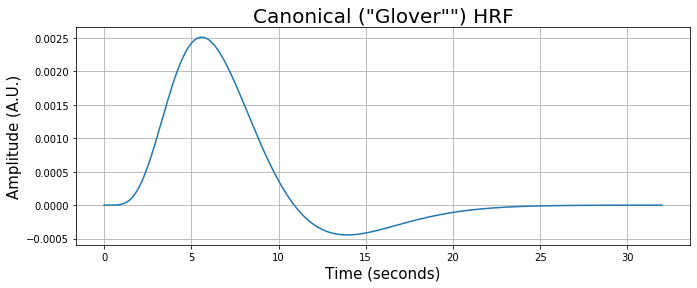

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define timepoints corresponding to HRF
t_hrf = np.linspace(0, 32, 32 * 100, endpoint=False)

plt.figure(figsize=(11, 4))
plt.plot(t_hrf, canon_hrf)
plt.grid()
plt.ylabel('Amplitude (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Canonical ("Glover"") HRF', fontsize=20)
plt.show()

<div class='alert alert-warning'>
    <b>ToDo</b>: Sometimes, people like to use a <em>basis set</em> of functions as a model for the HRF, such as the temporal and dispersion derivatives of the canonical HRF (in addition to the canonical HRF itself). The <tt>nistats</tt> package also includes these temporal and dispersion derivatives: <tt>glover_time_derivative</tt> and <tt>glover_dispersion_derivative</tt>. Import these functions, construct these HRF derivatives, and plot all three together in the same figure (like the one above).
</div>

In [64]:
''' Implement your ToDo here. (No test cell.) '''
from nistats.hemodynamic_models import glover_time_derivative 
from nistats.hemodynamic_models import glover_dispersion_derivative

time = glover_time_derivative(tr=1, oversampling=100)
dis = glover_dispersion_derivative(tr=1, oversampling=100)

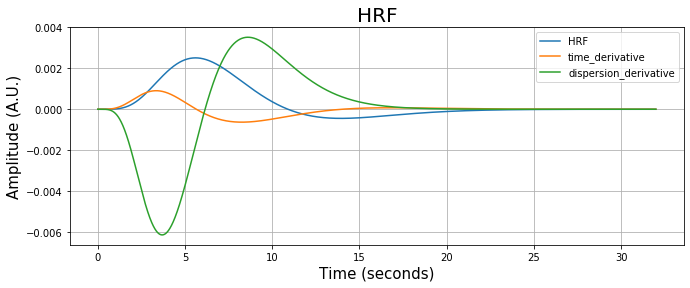

In [67]:
# Define timepoints corresponding to HRF
t_hrf = np.linspace(0, 32, 32 * 100, endpoint=False)

plt.figure(figsize=(11, 4))
plt.plot(t_hrf, canon_hrf)
plt.plot(t_hrf, time)
plt.plot(t_hrf, dis)


plt.grid()
plt.ylabel('Amplitude (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('HRF', fontsize=20)
plt.legend(["HRF","time_derivative","dispersion_derivative"])
plt.show()

### 3.2. Creating HRF-convolved regressors
Now, to create actual regressors, we need our event onsets and durations. At the lowest level interface, we only need the onsets, durations, and amplitudes (weights) of our events of a particular condition. For now, let's focus on the "strongly_accept" condition (note that you can define a "condition" using whatever feature from the experiment, such as the gains or losses, or even reaction time). There is no reason to focus only on these type of trials other than for the sake of the example:

In [68]:
idx = events_df.loc[:, 'participant_response'] == 'strongly_accept'
sa_events = events_df.loc[idx, ['onset', 'duration']]
sa_events['amplitude'] = 1  # set the same amplitude for each event
sa_events

,onset,duration,amplitude
1,11.834,4,1
2,19.535,4,1
6,50.535,4,1
16,122.131,4,1
17,128.232,4,1
18,135.634,4,1
19,141.237,4,1
23,171.423,4,1
25,188.726,4,1
26,195.427,4,1


The next step is to create an event regressor (basically arrays with zeros, containing ones at the onset of events) and convolving this array with our HRF model. We can do this easily using the `compute_regressor` function from the `nistats.hemodynamic_models` module:

In [69]:
from nistats.hemodynamic_models import compute_regressor

The most important arguments of this function are the following:
* `exp_condition`: an array of shape $3$ (onset, duration, amplitude) $\times N$ (events for a particular condition)
* `hrf_model`: a **string** indicating the HRF model ('spm', 'spm + derivative', 'spm + derivative + dispersion',
'glover', 'glover + derivative', 'glover + derivative + dispersion', 'fir')
* `frame_times`: an array of shape $T$ (timepoints of fMRI series) containing the acquisition time of each fMRI volume

First, let's define `exp_condition` by pulling out the array from `sa_events` (using the `.values` attribute of the `DataFrame`) and transposing it (otherwise it would be of the wrong shape, i.e., $N \times 3$).

In [70]:
exp_condition = sa_events.values.T
print(exp_condition.shape)

(3, 26)


Let's for simplicity just use a canonical (Glover) HRF:

In [72]:
hrf_model = 'glover'

And we'll define the frame times relative to the middle slice (i.e., assuming for simplicity that each slice was recorded at TR / 2):

In [74]:
n_vols = 453
tr = 1
frame_times = np.linspace(tr / 2, n_vols * tr + tr / 2, n_vols, endpoint=False)

Alright, now we have everything to compute the regressor using `compute_regressor`:

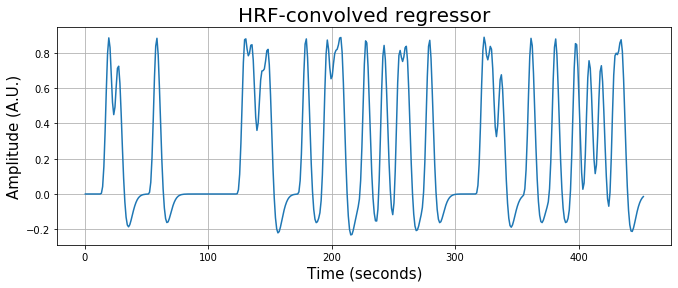

In [76]:
# The function compute_regressor returns two things:
# the convolved regressor(s) and a (default) name(s)
reg, name = compute_regressor(
    exp_condition=exp_condition,
    hrf_model=hrf_model,
    frame_times=frame_times
)

plt.figure(figsize=(11, 4))
plt.plot(frame_times, reg)
plt.grid()
plt.ylabel('Amplitude (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('HRF-convolved regressor', fontsize=20)
plt.show()

One of the analyses of NARPS project was to investigate the parametric effect of *gains* (i.e., the amount that could be gained for this trial), effectively asking: which voxels show activity that linearly relates to gains? For this analysis, you'd need both a simple "gamble-vs-baseline" regressor (like we computed before, but then for all trials instead of just the "strongly_accept" ones) and a "parametric modulation" regressor. This parametric modulation regressor uses the same onsets and durations as the "trial-vs-baseline" regressor, but *also* includes varying modulation values that indicate how much the effect of the gamble is modulated. Importantly, these modulation values should be mean-centered, i.e., its mean should be zero. You can mean-center any variable $x$ by subtracting the mean ($\bar{x}$) from all values:

\begin{align}
x_{\mathrm{mean-centered}} = x - \bar{x} 
\end{align}

<div class='alert alert-warning'>
    <b>ToDo</b> (optional): Create a parametric regressor that is modulated by the "gain" values. You can do this by making sure that the third row in the array that is passed as the <tt>exp_condition</tt> argument of <tt>compute_regressor</tt> reflects the mean-centered gain values. Store the resulting regressor in a variable named <tt>parametric_gain_reg</tt>.
</div>

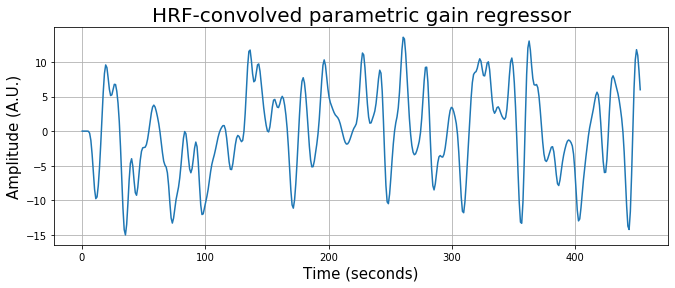

In [79]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
tmp = events_df.loc[:, ['onset', 'duration', 'gain']]
tmp = tmp.rename({'gain': 'amplitude'}, axis=1)
tmp.loc[:, 'amplitude'] = tmp.loc[:, 'amplitude'] - tmp.loc[:, 'amplitude'].mean()
parametric_gain_reg, _ = compute_regressor(
    exp_condition=tmp.values.T,
    hrf_model=hrf_model,
    frame_times=frame_times
)
plt.figure(figsize=(11, 4))
plt.plot(frame_times, parametric_gain_reg)
plt.grid()
plt.ylabel('Amplitude (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('HRF-convolved parametric gain regressor', fontsize=20)
plt.show()

In [80]:
''' Tests the above ToDo. '''
np.testing.assert_almost_equal(parametric_gain_reg.mean(), 0.0095463)
print("Well done!")

Well done!


### 3.3. Using the high-level `make_first_level_design_matrix` function
While the HRF-related functions and `compute_regressor` already take care of a lot of stuff for us, you might still think that constructing a complete design matrix this way is quite cumbersome. Fortunately, Nistats has a more high-level function for constructing complete design matrices easily called `make_first_level_design_matrix`:

In [85]:
from nistats.design_matrix import make_first_level_design_matrix

<div class='alert alert-warning'>
    <b>ToDo</b>: Go through the <a href="https://nistats.github.io/modules/generated/nistats.design_matrix.make_first_level_design_matrix.html#nistats.design_matrix.make_first_level_design_matrix">documentation</a> of the <tt>make_first_level_design_matrix</tt> function.
</div>

As you can see, this function needs (amongst other things) a `DataFrame` (events) containing the following columns: "onset", "duration", "trial_type", and (optionally) "modulation". Then, the function will basically apply the `compute_regressor` function across the different trial types as defined in the "trial_type" column. 

For now, let's assume that we'd want to create a design matrix with a different (un-modulated) regressor for each of the participant responses ("weakly_accept", "strongly_accept", "weakly_reject", and "strongly_reject"). Below, we'll create the appropriate `DataFrame` for this purpose:

In [88]:
# First, extract relevant columns
pr_events = events_df.loc[:, ['onset', 'duration', 'participant_response']]

# Then, rename the participant_response column to trial_type
# bonus: why do you think we have to specify axis=1 here?
pr_events = pr_events.rename({'participant_response': 'trial_type'}, axis=1)

# Lastly, create a "modulation" column with only ones (indicating no modulation)
pr_events.loc[:, 'modulation'] = 1  # this automatically fills all rows with 1
pr_events

,onset,duration,trial_type,modulation
0,4.071,4,weakly_accept,1
1,11.834,4,strongly_accept,1
2,19.535,4,strongly_accept,1
3,27.535,4,weakly_reject,1
4,36.435,4,strongly_reject,1
...,...,...,...,...
59,416.033,4,weakly_accept,1
60,421.734,4,strongly_accept,1
61,427.535,4,strongly_accept,1
62,435.636,4,strongly_reject,1


Now, the different conditions in our design are defined by the unique values in our `trial_type` column:

In [89]:
print(pr_events.loc[:, 'trial_type'].unique())

['weakly_accept' 'strongly_accept' 'weakly_reject' 'strongly_reject'
 'NoResp']


Ah darn, we also have 'NoResp' trials!

<div class='alert alert-warning'>
    <b>ToDo</b> Remove all 'NoResp' trials (i.e., rows) and store the new (filtered) <tt>DataFrame</tt> in a variable named <tt>pr_events_filt</tt>.
</div>

In [90]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
pr_events_filt = pr_events.loc[pr_events["trial_type"] != "NoResp"]

In [91]:
''' Tests the above ToDo. '''
assert('NoResp' not in pr_events_filt.loc[:, 'trial_type'].unique())
print("Well done!")

Well done!


<div class='alert alert-warning'>
    <b>ToDo</b> Now you're ready to use <tt>make_first_level_design_matrix</tt>! Use the appropriate arguments (at least <tt>frame_times</tt>, <tt>events</tt>, and <tt>hrf_model</tt>) and make sure to use <tt>drift_model=None</tt>.
   This will prevent Nistats from automatically adding a set of regressors to the design matrix which function as a high-pass filter (we'll take a look at this later). Store the output of the function in a new variable called <tt>dm</tt>, which should be a new pandas <tt>DataFrame</tt> of shape T (number of timepoints) x P (number of regressors, i.e., number of conditions + intercept). You can ignore the <tt>UserWarning</tt>.
</div>

In [94]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
dm = make_first_level_design_matrix(frame_times= frame_times, 
                                    events= pr_events_filt, 
                                    hrf_model="glover", 
                                    drift_model=None)


In [95]:
''' Tests the ToDo above. '''
assert(dm.shape == (453, 5))
np.testing.assert_array_equal(
    dm.columns,
    ['strongly_accept', 'strongly_reject', 'weakly_accept', 'weakly_reject', 'constant']
)
print("Well done!")

Well done!


Alright, almost done with this section. One last thing we want to show you is the `plot_design_matrix` function, which you can use to, well, plot the design matrix:

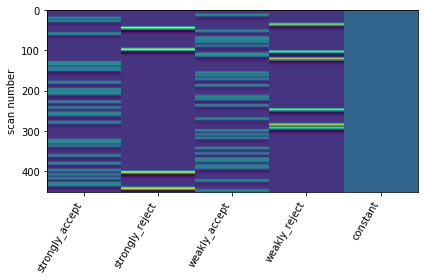

In [96]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(dm);

This plot shows you a "color-coded" version of your design matrix, with time on the y-axis and the different predictors on the x-axis. Note that the brighter the color (i.e., more yellow), the higher that regressor's value at that timepoint.

<div class='alert alert-warning'>
    <b>ToDo</b> Run <tt>make_first_level_design_matrix</tt> again, but add the following arguments: <tt>drift_model='cosine'</tt> and <tt>high_pass=0.01</tt> (i.e., in Hertz, corresponding to a cutoff of 100 seconds), which will add a set of cosine regressors to the design matrix, which function as a high-pass filter for our fMRI data. Store the design matrix in a new variable named <tt>dm_with_hp</tt>. Then, plot the design matrix again to see how it looks like!
</div>

/anaconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:65: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")


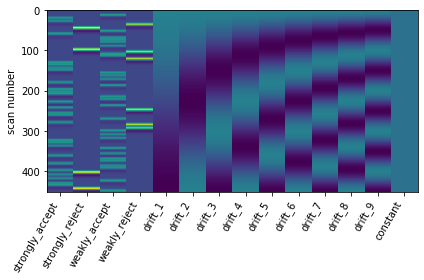

In [99]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
dm_with_hp = make_first_level_design_matrix(frame_times= frame_times, 
                                    events= pr_events_filt, 
                                    hrf_model="glover", 
                                    drift_model="cosine",
                                           high_pass=0.01)

plot_design_matrix(dm_with_hp);

In [100]:
''' Tests the above ToDo. '''
assert(dm_with_hp.shape == (453, 14))
assert(all(f'drift_{i}' in dm_with_hp.columns for i in range(1, 10)))
print("Well done!")

Well done!


## 4. First-level models
In this section, we will talk about fitting first-level models and computing contrasts from their estimated parameters.

### 4.1. Constructing and fitting first-level models
At last, we can start fitting first-level GLM models! Like with constructing design matrices, there are different ways to go about defining and fitting first-level models in Nistats:
* Using the low-level `run_glm` function;
* Using the `FirstLevelModel` class;
* Using the `first_level_models_from_bids` function

For most purposes, we recommend using the `FirstLevelModel` interface, which strikes a nice balance between flexibility (unlike the very high-level `first_level_models_from_bids` function) and ease-of-use (unlike the very low-level `run_glm` function).

Let's start by importing the `FirstLevelModel` class (you may ignore the FutureWarning):

In [101]:
# You may ignore the DeprecationWarning
from nistats.first_level_model import FirstLevelModel

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Note that, unlike the previous functionality from Nistats that we discussed, `FirstLevelModel` is not a *function*, but a custom *class* (often called a *type* in Python):

In [102]:
print(type(FirstLevelModel))

# Contrast this with for example 'make_first_level_design_matrix'
print(type(make_first_level_design_matrix))

<class 'type'>
<class 'function'>


Using custom classes, you can instantiate ("create") objects that behave as specified in the class. Before we go on, let's digress a little and discuss briefly how custom classes and object work.

One way to think about classes and objects is to see classes as *building blueprints* and the objects constructed from them as the *actual buildings*. For example, neuroimaging software in Python often work with MRI data stored in objects from the `Nifti1Image` class (from the `nibabel` package). An object is usually *constructed* from a class as follows:

```
some_object = SomeClass(optional_arg1, optional_arg2, optional_arg3, etc.)
```

For example, to construct a `Nifti1Image` object, we need to pass it both data (as a `numpy` array) and an affine (also as a `numpy` array):

In [103]:
import numpy as np

# Very small hypothetical brain image of 10x10x10
data = np.random.normal(0, 1, size=(10, 10, 10))
affine = np.eye(4)

# Here, we construct an object (nifti_obj) from a class (nib.Nifti1Image)
nifti_obj = nib.Nifti1Image(data, affine)
print(type(nifti_obj))

<class 'nibabel.nifti1.Nifti1Image'>


The class ("blueprint") contains instructions about the "properties" of the object ("building") and the "functionality" of the object. The "properties" of an object are, technically, called *attributes* and can be accessed as: `some_object.attribute_name`. For example, `Nifti1Image` objects have an attribute named `shape`:

In [104]:
print(nifti_obj.shape)

(10, 10, 10)


The "functionality" of objects are, technically, called *methods*. You can see methods as functions that are bound to a particular object. For example, `Nifti1Image` objects hava a method called `get_fdata`, which extract the actual brain data:

In [105]:
data = nifti_obj.get_fdata()
# 'data' is the underlying numpy array!
print(type(data))

<class 'numpy.ndarray'>


Note that you should call methods in the same way as functions (i.e., using round brackets, (), which may or may not contain arguments). Like functions, method calls may (or may not) return one or more things.

<div class='alert alert-success'>
    <b>Tip</b>: in Jupyter notebooks (and many other code editors), you can inspect an object's attributes and methods by typing the object's variable name followed by a dot and pressing <tt>tab</tt>, i.e., <tt>your_object.+TAB</tt>. Try it out below with the <tt>nifti_obj</tt> variable to inspect the different attributes/methods from the <tt>Nifti1Image</tt> class.
</div>

In [107]:
nifti_obj.ImageArrayProxy?


This topic of (custom) classes and objects is actually very important in Python. Technically, Python is an "object-oriented" programming language in which *everything is an object (from a particular class)*! But an in-depth explanation of object-oriented programming is beyond the scope of this tutorial. For now, knowing the basics about (custom) classes and objects suffices for our purposes.

Alright, back to the `FirstLevelModel` class. 

<div class='alert alert-warning'>
    <b>ToDo</b> Go through the <a href="https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html">documentation</a> of the <tt>FirstLevelModel</tt> class.

As you can see, initializing a `FirstLevelModel` object takes a lot of arguments (`t_r`, `slice_time_ref`, `hrf_model`, `drift_model`, etc.). Fortunately, many arguments have sensible defaults. In what follows, we'll go through the most important arguments step by step, after which we'll (finally!) construct a `FirstLevelModel` object.

The `t_r` argument refers to the TR (temporal resolution, in seconds) of your fMRI scan.

In [108]:
t_r = 1

The `slice_time_ref` argument refers to which slice you want resample your design matrix (this is used internally to define the `frame_times`), which should be between 0 (first slice) and 1 (last slice). For example, if you slice-time corrected your fMRI data to the first slice, you should set `slice_time_ref` to 0 (middle slice &rarr; 0.5, last slice &rarr; 1, etc.). If you did not apply any slice-time correction (as is the case for the NARPS data), we recommend setting it to 0.5. (Can you think of a reason why this is a sensible choice for non-slice-time-corrected data?)

In [109]:
slice_time_ref = 0.5

While you can construct your design matrix using Nistats functionality directly, you can actually also leave it up to the `FirstLevelModel` to do this for you! That's why you might have recognized some parameters that you've seen in functions from the previous section (such as `hrf_model`, `drift_model`, and `high_pass`). For now, we'll let the `FirstLevelModel` take care of constructing a design for us, so we'll define these parameters here:

In [111]:
hrf_model = 'glover'
drift_model = 'cosine'
high_pass = 0.01  # cutoff: 0.01 Hz (i.e., 100 seconds)

The next important parameter is `mask_img` (note that we're skipping some parameters, as they represent some more advanced functionality/analyses). This (optional!) parameter refers to a nifti image (a path to a nifti file or a `Nifti1Image` object) with binary (0, 1) data indicting which voxels should be included (1) and which ones should be "masked" (0). Fortunately, Fmriprep also returns a brain-mask:

In [112]:
mask_img = os.path.join(
    save_dir, 'derivatives', 'fmriprep', 'sub-001', 'func',
    'sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'
)
print(mask_img)

/Users/Dominik/NARPS/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz


Note that including a brain-mask may substantially speed up your analysis (as it reduces the number of voxels that will be analyzed).

We can also spatially smooth our fMRI data by setting the `smoothing_fwhm` parameter (in millimeters):

In [114]:
smoothing_fwhm = 3.5

Then, the `standardize` and `signal_scaling` parameters refer to the method that will be used to mean-center the data. In this example, we'll leave it to the default values (`standardize=False` and `signal_scaling=0`), which will only mean-center the data in the time domain (i.e., substract the mean across time from each voxel).

The `noise_model` parameter refers to the particular noise model of the GLM. Do we assume independent and identically distributed (IID) noise (`noise_model='ols'`) or do we assume that our noise is temporally autocorrelated (`noise_model='ar1'`)? For almost all fMRI data, we should assume that the noise is at least somewhat autocorrelated, so we'll set `noise_model` to `'ar1'`. (Note that `'ar1'` is a bit slower than `'ols'`, so you may consider using `'ols'` when for example testing your code.)

In [115]:
noise_model = 'ar1'

Then, the `n_jobs` parameter determines how many CPU cores the GLM analysis will use. For now, one core should suffice:

In [116]:
n_jobs = 1

Lastly, you may want to set the `minimize_memory` argument to `False`. While doing this will increase the memory (RAM) necessary for the GLM analysis, it allows use to retrieve more outputs from the GLM after fitting (such as model fit, $R^2$).

In [117]:
minimize_memory = False

Now we're *finally* ready to constuct our `FirstLevelModel` object!

In [118]:
flm = FirstLevelModel(
    t_r=t_r,
    slice_time_ref=slice_time_ref,
    hrf_model=hrf_model,
    drift_model=drift_model,
    high_pass=high_pass,
    mask_img=mask_img,
    smoothing_fwhm=smoothing_fwhm,
    noise_model=noise_model,
    n_jobs=n_jobs,
    minimize_memory=minimize_memory,
    verbose=True  # this will print out some useful info later
)

""" Note that, here, we've defined all arguments beforehand,
but this is not necessary! We could have done something like:
flm = FirstLevelModel(
    t_r=1,
    slice_time_ref=0.5,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01,
    mask_img=os.path.join(etc., etc.),
    smoothing_fwhm=3.5,
    noise_model='ar1',
    n_jobs=1,
    minimize_memory=False,
    verbose=True
)
""";

Wait, what? Did it really just take a fraction of a second to fit the first-level model? Actually, no. We only *constructed* the first-level model, but we haven't fitted it yet! To do so, we can use the, guess what, `fit` method!

<div class='alert alert-warning'>
    <b>ToDo</b>: in the <a href="https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html">documentation</a>, scroll down and read the documentation of the <tt>fit</tt> method. 
</div>

There are actually two ways of using the `fit` method, depending on which parameters you use:
1. define `events` (+ optionally `confounds`)
2. define `design_matrices`

Approach 1 will construct a design matrix for you (by running `make_first_level_design_matrix` on your `events` and, optionally, concatenating this with your `confounds`) while approach 2 assumes that you have constructed a design matrix yourself.

Note, by the way, that the parameter names are all plural (run_img**s**, event**s**, confound**s**, design_matrice**s**). This is because you can either fit a model on a *single* fMRI run or fit a model on *multiple* fMRI runs with a single `fit` call. To fit multiple runs, just pass a list instead of a single object for each parameter (e.g., `design_matrices=[dm_run1, dm_run2]` instead of `design_matrices=dm`). 

Regardless of the approach for constructing your design matrix, the `fit` method always needs (one or more) fMRI files (for the `run_img` parameter), which can either be a `Nifti1Image` object or string representing the path to a 4D nifti file. Furthermore, both the `events` and the `confounds` should be a Pandas `DataFrame`. For our `events`, let's use the `pr_events_filt` events, in which the participant responses represent our conditions:

In [119]:
# This is also one possible solution to the ToDo earlier
events2use = pr_events.loc[pr_events.loc[:, 'trial_type'] != 'NoResp', :]

Almost always, you'd want to add some confounds to your design matrix, as confounds represent independent variables that are (often) not of interest to the researcher, but might be related to the signal (the depenent variable, $y$) anyway. Including these confounds in your design matrix will then explain some variance that might otherwise not be accounted for (which will "end up" in the model's noise term, $\hat{\sigma}^2$), increasing the model's power to detect effects related to the variables you're interested in. Note that including the "right" confounds in your model is in no way trivial (and opinions differ to what confounds are the "right" ones to include)!

That siad, fortunately, Fmriprep also computes an extensive set of timepoint-by-timepoint confounds for each fMRI run, which are conveniently stored in TSV files. (You can really see that Nistats was designed with Fmriprep's outputs in mind.) We'll load these confounds below:

In [120]:
conf_path = os.path.join(save_dir, 'derivatives', 'fmriprep', 'sub-001', 'func', 'sub-001_task-MGT_run-01_bold_confounds.tsv')
confounds = pd.read_csv(conf_path, sep='\t')
confounds

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,Cosine03,Cosine04,Cosine05,NonSteadyStateOutlier00,X,Y,Z,RotX,RotY,RotZ
0,6551.2820,6476.4653,9874.576,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000
1,6484.7285,6473.4890,9830.212,1.090467,52.782734,1.059437,0.135279,0.026310,-0.067307,0.093488,...,0.066513,0.066509,0.066505,0.0,-0.009969,-0.031344,-0.000003,0.001327,-3.841930e-04,-0.000168
2,6441.5337,6485.7256,9821.212,1.075201,52.043827,1.038219,0.124377,-0.040482,0.034151,0.136612,...,0.066461,0.066429,0.066389,0.0,-0.000026,-0.009237,0.054967,0.000997,-1.974500e-04,-0.000399
3,6401.1150,6481.4287,9808.847,1.054436,51.038681,1.024683,0.141592,0.041604,0.043600,0.019408,...,0.066358,0.066268,0.066158,0.0,-0.000033,0.057941,0.069283,0.000115,-3.759120e-24,-0.000277
4,6428.2754,6486.5215,9800.982,1.033018,50.001972,1.008018,0.050009,0.039142,-0.048557,0.002349,...,0.066204,0.066028,0.065812,0.0,-0.000028,0.066681,0.047148,-0.000131,-0.000000e+00,-0.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,6283.9775,6351.6470,9709.042,0.965847,46.750648,0.942527,0.163531,0.029389,0.050830,-0.003066,...,0.065999,-0.065707,0.065351,0.0,0.145591,0.580718,-0.197908,0.019242,-5.842150e-03,0.006432
449,6288.5166,6358.2890,9699.646,0.962312,46.579544,0.937389,0.123842,0.020375,-0.052627,0.022244,...,0.066204,-0.066028,0.065812,0.0,0.144689,0.497605,-0.164401,0.019367,-5.840740e-03,0.006432
450,6275.0960,6351.5800,9689.500,0.961982,46.563568,0.934215,0.092524,-0.045895,0.026748,0.015520,...,0.066358,-0.066268,0.066158,0.0,0.146489,0.523339,-0.140874,0.019632,-6.006700e-03,0.006831
451,6292.8433,6343.4766,9685.282,0.952871,46.122551,0.933991,0.128236,0.038074,0.006421,-0.049293,...,0.066461,-0.066429,0.066389,0.0,0.150766,0.572870,-0.168183,0.018983,-5.862430e-03,0.006682


<div class='alert alert-warning'>
    <b>ToDo</b>: Read the Fmriprep <a href="https://fmriprep.readthedocs.io/en/stable/outputs.html">documentation</a> about the different confounds (scroll down to the "Confounds" section). Note that the confound names in the documentation are slightly different that in our <tt>DataFrame</tt> because this dataset was preprocessed using an older version of Fmriprep.
</div>

As stated in Fmriprep's documentation, it's probably not a good idea to include *all* confounds in our model. Selecting a subset of confound parameter is, however, also not a trivial matter; which confounds are appropriate and explain to most variance in your data likely depends on the characteristics of your particular dataset (field strength, scan technique, the amount of motion in your data, etc.) and your intended analysis (univariate group-level GLM, functional connectivity, MVPA).

Here, we'll be relatively conservative and include only the 6 motion parameters (`X`, `Y`, `Z`, `RotX`, `RotY`, `RotZ`) and the non-steady-state outlier (`NonSteadyStateOutlier00`; i.e., a binary-coded regressor removing the influence of volumes at the beginning of a run that contain too much T1-contrast).

In [121]:
confounds2use = confounds.loc[:, ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ', 'NonSteadyStateOutlier00']]
confounds2use

,X,Y,Z,RotX,RotY,RotZ,NonSteadyStateOutlier00
0,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,0.000000,1.0
1,-0.009969,-0.031344,-0.000003,0.001327,-3.841930e-04,-0.000168,0.0
2,-0.000026,-0.009237,0.054967,0.000997,-1.974500e-04,-0.000399,0.0
3,-0.000033,0.057941,0.069283,0.000115,-3.759120e-24,-0.000277,0.0
4,-0.000028,0.066681,0.047148,-0.000131,-0.000000e+00,-0.000140,0.0
...,...,...,...,...,...,...,...
448,0.145591,0.580718,-0.197908,0.019242,-5.842150e-03,0.006432,0.0
449,0.144689,0.497605,-0.164401,0.019367,-5.840740e-03,0.006432,0.0
450,0.146489,0.523339,-0.140874,0.019632,-6.006700e-03,0.006831,0.0
451,0.150766,0.572870,-0.168183,0.018983,-5.862430e-03,0.006682,0.0


In fact, we can reuse the `plot_design_matrix` function to visualize this "confound design matrix":

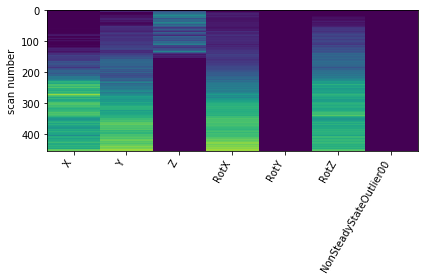

In [124]:
ax = plot_design_matrix(confounds2use)
# Rescale the colors a little
ax.get_images()[0].set_clim(0, 0.1)

Alright, now we can *finally* fit our model (this may take 2-5 minutes or so, depending on how fast your computer/server is; go get some coffee)!

In [127]:
flm.fit(run_imgs=fmri, events=events2use, confounds=confounds2use)

Computing run 1 out of 1 runs (go take a coffee, a big one)
/anaconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:65: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")

Computation of 1 runs done in 65 seconds



FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                high_pass=0.01, hrf_model='glover',
                mask_img='/Users/Dominik/NARPS/derivatives/fmriprep/sub-001/func/sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
                memory=Memory(location=None), memory_level=1, min_onset=-24,
                minimize_memory=False, n_jobs=1, noise_model='ar1',
                signal_scaling=True, slice_time_ref=0.5, smoothing_fwhm=3.5,
                standardize=False, subject_label=None, t_r=1,
                target_affine=None, target_shape=None, verbose=True)

The `fit` function doesn't return the results of the GLM analysis, but stores it as attributes. This includes the constructed design matrix (or matrices, when there is more than one run):

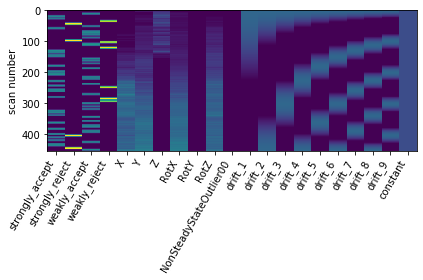

In [128]:
# the design_matrices_ attribute is a list with, in our case, only a single
# element
flm_dm = flm.design_matrices_[0]

# Let's plot it again
ax = plot_design_matrix(flm_dm)
ax.get_images()[0].set_clim(0, 0.2)

Another result from the GLM that we can inspect is model fit, expressed as $R^2$ (only when `minimize_memory=False`):

In [129]:
# Again, it returns a list, and we'll take the first element,
# because we only have one run
r2_img = flm.r_square[0]

The `r2_img` variable is a 3D `Nifti1Image` object with voxelwise $R^2$ values. We can visualize this using the `plotting` module from Nilearn (e.g., using `plot_stat_map` with an arbitrary threshold of 0.2):

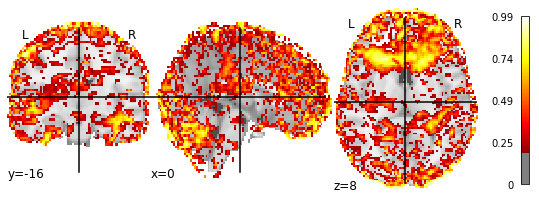

In [134]:
from nilearn import plotting
plotting.plot_stat_map(r2_img, threshold=0.2);

Another thing we can inspect is the residual time series from the model fit, which we can retrieve using the `residuals` attribute (you can ignore the `FutureWarning`):

In [136]:
resids = flm.residuals[0]
print(type(resids))
print(resids.shape)

/anaconda3/lib/python3.6/site-packages/nistats/regression.py:339: FutureWarning: 'resid' from RegressionResults has been deprecated and will be removed. Please use 'residuals' instead.
  FutureWarning,


<class 'nibabel.nifti1.Nifti1Image'>
(97, 115, 81, 453)


<div class='alert alert-warning'>
    <b>ToDo</b> (optional): If you want to brush up your Nilearn skills, try computing the standard deviation across time for each voxel in the <tt>resids</tt> variable. Store the result (a <tt>Nifti1Image</tt>) in a new variable called <tt>r_std</tt>. Then, plot the result using <tt>plot_stat_map</tt> using a threshold of 3. You should clearly see the brain's veins and contours (effects of movement?) in the plot! Hint: perhaps the function <tt>nilearn.image.math_img</tt> is of use here ... (but this ToDo can be implemented in various ways)
</div>

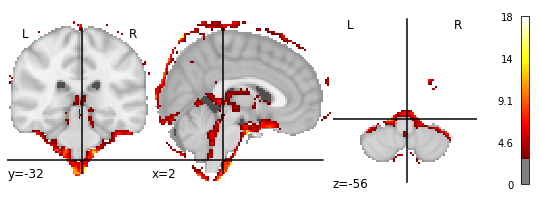

In [138]:
''' Implement the (optional) ToDo here. '''
# YOUR CODE HERE
from nilearn import image

r_std = image.math_img('img.std(axis=-1)', img=resids)
plotting.plot_stat_map(r_std, threshold=3)

In [140]:
''' Tests the above ToDo. '''
np.testing.assert_almost_equal(r_std.get_fdata().mean(), 0.348651)
print("Well done!")

Well done!


### 4.2. Computing contrasts from first-level models
The last thing we'll discuss in this section is computing contrasts and thresholding the resulting statistical images. Computing contrasts using `FirstLevelModel` objects is ridiculously easy. This is done using the `compute_contrast` method.

<div class='alert alert-warning'>
    <b>ToDo</b>: in the <a href="https://nistats.github.io/modules/generated/nistats.first_level_model.FirstLevelModel.html">documentation</a>, of the <tt>FirstLevelModel</tt> class, read the documentation of <tt>compute_contrast</tt> method. 
</div>

The `contrast_def` parameter represents the contrast you want compute and can be used in different ways. One way is to specify a contrast vector (a list or a numpy array). For example, if we'd like to evaluate the contrast "strongly_accept > baseline", we could specify the contrast vector as follows:

In [145]:
con_vec = np.zeros(flm.design_matrices_[0].shape[1])
con_vec[0] = 1
print(con_vec)
print(con_vec.shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(21,)


Note that values of the contrast vector are assumed to relate to the regressors froms the design matrix in the same order (e.g., the first value from the contrast vector corresponds to the first regressor in your design matrix, i.e., the first column).

Then, we can compute the contrast as following (assuming a single contrast, i.e., `stat_type='t'`, and wanting $z$-values as output, i.e., `output_type='z_score'`):

In [148]:
con_img = flm.compute_contrast(con_vec, stat_type='t', output_type='z_score')

How does that look like?

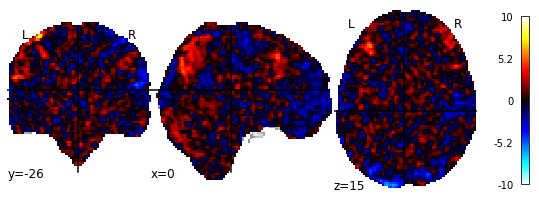

In [149]:
plotting.plot_stat_map(con_img)

The same contrast can be evaluated by using a string describing a "formula". In the "strongly_accept > baseline" contrast, this is trivial:

In [150]:
con_img2 = flm.compute_contrast('strongly_accept', stat_type='t', output_type='z_score')
# check that it is literally the same; if it's not, it will give an error
np.testing.assert_array_equal(con_img.get_fdata(), con_img2.get_fdata())

But we can also define more complicated contrasts, such as "(strongly_accept + weakly_accept) > strongly_reject" (note that this is theoretically a nonsense contrast and just used for the sake of the example):

In [151]:
# Note: the same contrast can be defined using the contrast vector:
# [1, -2, 1, 0, 0, 0, 0, ..., 0]
contrast_def = 'strongly_accept + weakly_accept - 2*strongly_reject'
con_img = flm.compute_contrast(contrast_def, stat_type='t', output_type='z_score')

Note that $z$-values are not the only output type possible. The other options are:
* `'stat'`: either the $t$-value or $F$-value, depending on `stat_type`;
* `'p_value'`: the $p$-value associated with the $t$ of $F$-value;
* `'effect_size'`: the dot product of the contrast vector and the parameters ($c\hat{\beta}$);
* `'effect_variance'`: the variance of the dot product of the contrast vector and the parameters ($\mathrm{var}[c\hat{\beta}]$);
* `'all'`: all of the above

<div class='alert alert-warning'>
    <b>ToDo</b>: Using either the "formula" format or the contrast vector format, compute the $t$-values associated with the contrast "reject > accept" (regardless of strongly/weakly). Store the resulting image in a variable named <tt>reject_gt_accept</tt> (gt = greater than) and plot the image using <tt>plot_stat_map</tt>.
</div>

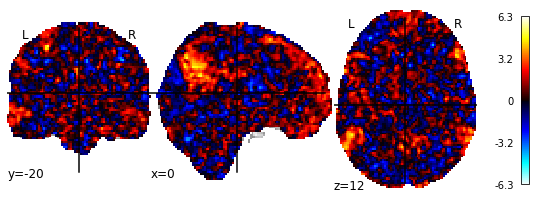

In [165]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
re_gt_ac = np.zeros(flm.design_matrices_[0].shape[1])
re_gt_ac[:4] = [-1, 1, -1 , 1]
#print(re_gt_ac)

reject_gt_accept = flm.compute_contrast(re_gt_ac, stat_type='t', output_type='stat')

plotting.plot_stat_map(reject_gt_accept)

In [167]:
''' Tests the above ToDo. '''
np.testing.assert_almost_equal(reject_gt_accept.get_fdata().mean(), 0.0488122)
print("Well done!")

Well done!


You can also compute $F$-tests by providing *multiple* contrasts as a list (of either "formula" strings or contrast vectors):

In [168]:
contrast_def = [
    'strongly_accept',
    'weakly_accept',
    'strongly_reject',
    'weakly_reject'
]

# The same could be done by:
# constrast_def = [
#      [1, 0, 0, 0, 0, ..., 0],
#      [0, 1, 0, 0, 0, ..., 0],
#      [0, 0, 1, 0, 0, ..., 0]
# ]
f_img = flm.compute_contrast(contrast_def, stat_type='F', output_type='stat')

/anaconda3/lib/python3.6/site-packages/nistats/first_level_model.py:587: UserWarning: One contrast given, assuming it for all 1 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


So far, we plotted the resulting statistic maps without a threshold (or an arbitrary one), but in a proper analysis, you'd want to statistically threshold your image to reduce the risk of false positives. In Nilearn, this can be done using the function `map_threshold`.

In [170]:
from nistats.thresholding import map_threshold

<div class='alert alert-warning'>
    <b>ToDo</b>: Read the <a href="https://nistats.github.io/modules/generated/nistats.thresholding.map_threshold.html#nistats.thresholding.map_threshold">documentation</a> of the <tt>map_threshold</tt> function. 
</div>

As you can see, the primary input to the `map_threshold` function (i.e., `stat_img`) is assumed to consist of $z$-values. 

Using `map_threshold`, there are various ways of thresholding your statistical map. Your desired method can be indicated using the `height_control` parameter (either 'fpr', 'fdr', or 'bonferroni', where 'fpr' refers to simple p-value based thresholding without multiple comparison control). The `alpha` parameter represents the significance level that should be used. There is also an option to only include significant voxels that belong to a cluster larger than a certain amount of voxels using `cluster_threshold` (which can make plots a little more visually appealing), but realize that this is by no means a method that guarantees proper false positive control.

Importantly, the `map_threshold` function optionally takes a mask (`mask_img`), which improves sensitivity a lot when using, for example, Bonferroni correction which depends on the number of tests. Also, note that the `map_threshold` function returns two things: the thresholded map and the threshold that was actually used.

Anyway, let's focus on the "strongly_reject > baseline" contrast and let's threshold it using the `'bonferroni'` method with an `alpha` of 0.01 while included the previously defined mask:

5.180082727205317


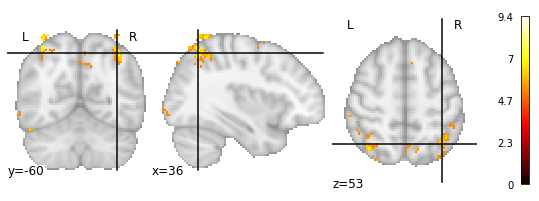

In [171]:
con_img = flm.compute_contrast('strongly_reject', stat_type='t', output_type='z_score')
con_img_thr, used_threshold = map_threshold(con_img, mask_img=mask_img, height_control='bonferroni', alpha=0.05)
plotting.plot_stat_map(con_img_thr)
print(used_threshold)

<div class='alert alert-warning'>
    <b>ToDo</b>: threshold the same image (<tt>con_img</tt>), but this time using 'fdr' correction, an alpha of 0.01 and a cluster threshold of 100. Store the result in a variable named <tt>con_img_thr_fdr</tt>.
</div>

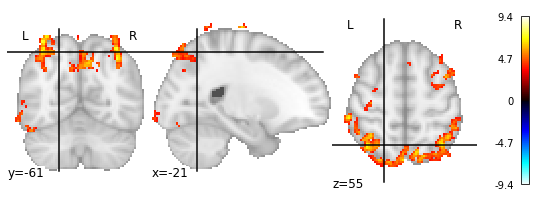

In [172]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
con_img_thr_fdr, used_threshold = map_threshold(con_img, mask_img=mask_img, height_control='fdr', alpha=0.01,
                                               cluster_threshold=100)

plotting.plot_stat_map(con_img_thr_fdr)


In [173]:
''' Tests the above ToDo. '''
np.testing.assert_almost_equal(con_img_thr_fdr.get_fdata().mean(), 0.0318363)
print("Well done!")

Well done!


Before we go on to the next section, we want to show you one last nugget: the `make_glm_report` function (see [documentation](https://nistats.github.io/modules/generated/nistats.reporting.make_glm_report.html#nistats.reporting.make_glm_report)). This function takes an *already fitted* `FirstLevelModel` object, a contrast definition, and optionally several parameters related to computing and thresholding the statistic image(s) and returns a summary of the results (as an HTML file, which can be nicely rendered in Jupyter notebooks).

In [174]:
from nistats.reporting import make_glm_report
# This may take a couple of seconds
# You can use your trackpad or keyboard keys to navigate the cell below
# (make sure you are in "edit" mode, i.e., the cell border should be blue;
#  click the cell to enter "edit" mode)
make_glm_report(flm, 'strongly_accept - weakly_accept')

In [175]:
# Let's clear up some memory for the last section
%reset -f

## 5. Second-level models
The only major Nistats functionality that we haven't discussed is *second-level models*. Unlike first-level models, there is basically only one way to fit second-level models: using the `SecondLevelModel` class.

In [176]:
from nistats.second_level_model import SecondLevelModel

<div class='alert alert-warning'>
    <b>ToDo</b>: read the <a href="https://nistats.github.io/modules/generated/nistats.second_level_model.SecondLevelModel.html">documentation</a> of the <tt>SecondLevelModel</tt> class.
</div>

The second-level model class allows you to run random-effects (but not mixed-effects!) models on multiple participants. Note that it assumes that all data have been registered/resampled to a common space (e.g., MNI, such as our data). It's interface is very similar to the `FirstLevelModel` class (i.e., it also has a `fit` and `compute_contrast` method). When constructing a `SecondLevelModel` object, the most important parameters are `mask_img`, an optional mask, and `smoothing_fwhm`, an optional smoothing kernel.

For our example, let's do a (horribly underpowered) group-level analysis of the two subjects whose data we downloaded. First of all, we need to fit both first-level models. We'll define a function below that does this for a single subject:

In [177]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from glob import glob
from tqdm import tqdm_notebook
from nilearn import masking
from nistats.first_level_model import FirstLevelModel

def fit_firstlevel(sub, bids_dir, task='MGT', run='01', space='MNI152NLin2009cAsym', 
                   conf_cols=None, **flm_kwargs):
    """ Example function of how you could implement a complete
    first-level analysis for a single subject. Note that this is
    just one way of implementing this; there may be (much more efficient)
    ways to do this.
    
    Parameters
    ----------
    sub : str
        Subject-identifier (e.g., 'sub-01')
    bids_dir : str
        Path to BIDS directory (root directory)
    task : str
        Name of task to analyse
    run : str
        Name of run to analyze
    space : str
        Name of space of the data
    conf_cols : list (or None)
        List of confound names to include; if None, only 6 motion params
        are included
    **flm_kwargs : kwargs
        Keyword arguments for the FirstLevelModel constructor
    
    Returns
    -------
    flm : FirstLevelModel
        Fitted FirstLevelModel object
    """
    
    # If conf_cols is not set, let's use a "standard" set of
    # motion parameters (translation and rotation in 3 dimensions)
    if conf_cols is None:
        # Note: in new versions of Fmriprep, these variables are named differently,
        # i.e., trans_x, trans_y, trans_z, rot_x, rot_y, rot_z
        conf_cols = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']

    # We assume it's a BIDS formatted dataset with the Fmriprep outputs in
    # bids_dir/derivatives/fmriprep
    bids_func_dir = os.path.join(bids_dir, sub, 'func')
    fprep_func_dir = os.path.join(bids_dir, 'derivatives', 'fmriprep', sub, 'func')
    
    # Let's find the fMRI files, given a particular space (e.g., T1w)
    funcs = sorted(glob(os.path.join(fprep_func_dir, f'*space-{space}*_preproc*.nii.gz')))

    # In this loop, we'll find the events/confounds/masks associated with the funcs
    confs, events, masks = [], [], []
    for func in funcs:
        # First, find the associated mask
        # Note, this doesn't work for newer versions of Fmriprep, which uses
        # a slightly different naming convention for brainmasks (desc-brain_mask)
        mask_path = func.replace('preproc', 'brainmask')
        masks.append(mask_path)

        # Find the associated confounds file
        conf_path = func.replace(f'space-{space}_preproc.nii.gz', 'confounds.tsv')
        conf_df = pd.read_csv(conf_path, sep='\t').loc[:, conf_cols]
        confs.append(conf_df)
        
        # Find the associated events file
        event_path = os.path.join(bids_dir, sub, 'func', f'{sub}_task-{task}_run-{run}_events.tsv')
        event_df = pd.read_csv(event_path, sep='\t')
        
        # Exclude 'NoResp' trials (not strictly necessary)
        event_df = event_df.query("participant_response != 'NoResp'")
        
        # Set participant_response as the trial_type
        event_df = event_df.rename({'participant_response': 'trial_type'}, axis=1)
        events.append(event_df)

    # In case there are multiple masks, create an intersection;
    # if not, this function does nothing
    mask_img = masking.intersect_masks(masks, threshold=0.8)

    # Construct the first-level model!
    # We set the t_r to the first func we have, assuming
    # that the TR is the same for each run (if there are multiple runs)
    flm = FirstLevelModel(
        t_r=nib.load(func).header['pixdim'][4],
        slice_time_ref=0.5,
        mask_img=mask_img,
        **flm_kwargs
    )
    
    # Finally, fit the model and return the fitted model
    flm.fit(run_imgs=funcs, events=events, confounds=confs)
    return flm

Now we can create a loop across our two subjects, estimating a first-level model for each:

In [178]:
bids_dir = os.path.join(os.path.expanduser('~'), 'NARPS')
flms = []

# This may take about 2-10 minutes, go get some coffee!
for sub in tqdm_notebook(('sub-001', 'sub-003')):
    flm = fit_firstlevel(sub, bids_dir, drift_model='cosine', high_pass=0.1)
    flms.append(flm)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Alright, so now we have two fitted `FirstLevelModel` objects (stored in `flms`). We will use these for our second-level model. Like `FirstLevelModel` objects, the `SecondLevelModel` object has a `fit` method, but it is a bit more complicated, because there are different ways to specify the input for second-level models (i.e., the `second_level_input` parameter):
1. a list of fitted `FirstLevelModel` objects (easy, but limited to within-subject/run analyses only);
2. a list of first-level contrast images (i.e., with $c\hat{\beta}$ values);
3. a pandas `DataFrame` with information about the lower-level inputs (useful when using first-level output from other packages, such as FSL, but for Nistats-only analyses, this is not very useful)

The first method is quite efficient (in terms of code), because it assumes that you are only interested in an intercept-only group-level model (i.e., the average of a particular first-level contrast across participants), and you can leave out the second-level design matrix. We'll show this below:

In [181]:
# We don't supply any mask for simplicity
slm_method1 = SecondLevelModel(smoothing_fwhm=5)
slm_method1.fit(flms)  # we don't have give it a design matrix!

SecondLevelModel(mask_img=None, memory=Memory(location=None), memory_level=1,
                 minimize_memory=True, n_jobs=1, smoothing_fwhm=5, verbose=0)

The second option is to give the `SecondLevelModel` a list of first-level contrast images in combination with a second-level design matrix. First, let's compute a first-level contrast (say "strongly_accept") for both participants:

In [182]:
fl_cons = []
for flm in flms:
    con = flm.compute_contrast('strongly_accept', stat_type='t', output_type='effect_size')
    fl_cons.append(con)

Now we only need to construct a second-level design matrix, which should be a pandas `DataFrame`. The columns in this `DataFrame` represent the different predictors for our second-level model. For simplicity, let's just define an intercept-only design matrix (exactly the same as we did using method 1):

In [183]:
# Specifying the index is not stringly necessary, but it looks nice
slm_dm = pd.DataFrame([1, 1], columns=['intercept'], index=('sub-001', 'sub-003'))
slm_dm

,intercept
sub-001,1
sub-003,1


Using the first-level contrast images (`fl_cons`) and the second-level design matrix (`slm_dm`), we can fit our second-level model:

In [184]:
slm_method2 = SecondLevelModel(smoothing_fwhm=5)
slm_method2.fit(fl_cons, design_matrix=slm_dm)

SecondLevelModel(mask_img=None, memory=Memory(location=None), memory_level=1,
                 minimize_memory=True, n_jobs=1, smoothing_fwhm=5, verbose=0)

Using this fitted second-level model for either method, we can also compute second-level contrasts. The way this is done is slightly different for each method. For method 1 (using fitted `FirstLevelModel` objects as inputs), the only option is to use the `first_level_contrast` parameter in the `compute_contrast` method. You can only use contrast definitions that were already present in the first-level model (because there is no second-level design matrix). 

For example, if we'd want to compute the average (across participants) group-level contrast of "strongly_accept > baseline", we'd do:

In [185]:
sr_average_method1 = slm_method1.compute_contrast(first_level_contrast='strongly_accept', output_type='z_score')

For method 2 (using first-level contrast images + a second-level design matrix), we cannot use the `first_level_contrast` parameter; instead, we should use the `second_level_contrast` parameter, which applies to contrasts based on the second-level design matrix. Because we also defined an intercept-only model for method 2, the only contrast we *can* evaluate is the intercept contrast:

In [186]:
sr_average_method2 = slm_method2.compute_contrast(second_level_contrast='intercept', output_type='z_score')

Note that the the results from both methods are virtually the same; the only difference is the way we used the `SecondLevelModel` interface. 

<div class='alert alert-warning'>
    <b>ToDo</b> Alright then, one last ToDo! Suppose that we want to construct a group-level model that investigates the difference between the first-level "strongly_accept" contrast images from sub-001 and sub-003 (a nonsensical analysis for just two subjects, but just ignore that for now). Can you construct an appropriate second-level design matrix for this analysis? Store this design matrix (a <tt>DataFrame</tt>) in a variable called <tt>slm_dm_todo</tt>.
</div>

In [188]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
slm_dm_todo = pd.DataFrame([[1, 0], [0, 1]], columns=['s1', 's2'])
slm_dm_todo


,s1,s2
0,1,0
1,0,1


In [189]:
''' Tests the above ToDo. '''
np.testing.assert_array_equal(slm_dm_todo.sum(axis=0).values, [1, 1])
np.testing.assert_array_equal(slm_dm_todo.sum(axis=1).values, [1, 1])
print("Well done!")

Well done!


## Concluding remarks
Hopefully this tutorial gave you an idea how to use Nistats! We recommend you check out the ample excellent tutorials and examples on the Nistats [website](https://nistats.github.io/) or to check out the codebase on [Github](https://github.com/nistats/nistats). As said before, Nistats is a relatively novel project and its codebase may still change, so keep an eye out for new releases and extended functionality!

That said, we hope that this tutorial helps you to get started with your analyses using Nistats.<br>
Happy hacking!